In [36]:
import csv
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
from datetime import datetime
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,f1_score,mean_squared_error
from sklearn.model_selection import cross_val_predict
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 100)
sns.set(rc={'figure.figsize':(25,15)},font_scale=2)

1. changing into float
2. mean of the each category o
3. redefine the loan grade
4. convert to numeric
5. simple correlation
6. x1.hist
7. drop columns from dummies without information
8. X20, states, too much dummies -> just get the states that are larger than >10000 and drop others
9. using only categorical variables  describe (ipyhon,html
10. x16 is empty on the test set
11. x17 >5000
12. check overfitting
13. min_max scaler
14. random forest check feature importance and discover that feature 4 is very importatnt. redo feature selection if needed
15. then models


### Import data

In [37]:
loan=pd.read_csv('Data for Cleaning & Modeling.csv')

In [38]:
loan_heldout=pd.read_csv('Holdout for Testing.csv')

In [39]:
loan.replace(r'\%','', inplace=True, regex=True)
loan.replace(r'\$','', inplace=True, regex=True)
loan.replace(r'\,','', inplace=True, regex=True)

In [40]:
loan_heldout.replace(r'\%','', inplace=True, regex=True)
loan_heldout.replace(r'\$','', inplace=True, regex=True)
loan_heldout.replace(r'\,','', inplace=True, regex=True)

In [41]:
loan[['X1','X4','X5','X6','X30']]=loan[['X1','X4','X5','X6','X30']].apply(pd.to_numeric)

In [42]:
loan_heldout[['X1','X4','X5','X6','X30']]=loan_heldout[['X1','X4','X5','X6','X30']].apply(pd.to_numeric)

In [257]:
loan.dtypes

X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6     float64
X7      object
X8      object
X9      object
X10     object
X11     object
X12     object
X13    float64
X14     object
X15     object
X16     object
X17     object
X18     object
X19     object
X20     object
X21    float64
X22    float64
X23     object
X24    float64
X25    float64
X26    float64
X27    float64
X28    float64
X29    float64
X30    float64
X31    float64
X32     object
dtype: object

In [258]:
loan_heldout.dtypes

X1     float64
X2       int64
X3       int64
X4       int64
X5       int64
X6       int64
X7      object
X8      object
X9      object
X10     object
X11     object
X12     object
X13    float64
X14     object
X15     object
X16     object
X17     object
X18     object
X19     object
X20     object
X21    float64
X22      int64
X23     object
X24      int64
X25    float64
X26    float64
X27      int64
X28      int64
X29      int64
X30    float64
X31      int64
X32     object
dtype: object

In [43]:
columns=pd.read_csv('Metadata.csv',encoding='latin1')
columns=columns['Definition']

In [260]:
loan.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89,54734.0,80364.0,25000.0,25000.0,19080.0,36 months,B,B4,NaN,< 1 year,RENT,85000.0,VERIFIED - income,Aug-09,Due to a lack of personal finance education and exposure to poor financing skills growing up I was easy prey for credit predators. I am devoted to becoming debt-free and can assure my lenders that I will pay on-time every time. I have never missed a payment during the last 16 years that I have had credit.,debt_consolidation,Debt consolidation for on-time payer,941xx,CA,19.48,0.0,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.1,42.0,f
1,10.71,55742.0,114426.0,7000.0,7000.0,673.0,36 months,B,B5,CNN,< 1 year,RENT,65000.0,not verified,May-08,Just want to pay off the last bit of credit card debt at a better rate.,credit_card,Credit Card payoff,112xx,NY,14.29,0.0,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.7,7.0,f
2,16.99,57167.0,137225.0,25000.0,25000.0,24725.0,36 months,D,D3,Web Programmer,1 year,RENT,70000.0,VERIFIED - income,Aug-14,Trying to pay a friend back for apartment broker's fee incurred from as well as credit card stuff.,debt_consolidation,mlue,100xx,NY,10.50,0.0,Jun-00,0.0,41.0,NaN,10.0,0.0,19878.0,66.3,17.0,f
3,13.11,57245.0,138150.0,1200.0,1200.0,1200.0,36 months,C,C2,city of beaumont texas,10+ years,OWN,54000.0,not verified,Mar-10,If funded I would use this loan consolidate two loans with interest rates of 15 and 16 percent respectively. I have no mortgage. One car is paid for and the other I bought from my sister. I pay her 200 / month. I owe her about 1000. The biggest monthly expense we have is tuition for two kids going to Catholic School (600 / month). I have been on the same job since 1990 with a salary of 54000. My husband has been on the same job since 1995 with a salary of 30000. My monthy expenses...,debt_consolidation,zxcvb,777xx,TX,5.47,0.0,Jan-85,0.0,64.0,NaN,5.0,0.0,2584.0,40.4,31.0,f
4,13.57,57416.0,139635.0,10800.0,10800.0,10692.0,36 months,C,C3,State Farm Insurance,6 years,RENT,32000.0,not verified,Nov-09,I currently have a personal loan with Citifinancial that I have a high interest rate on I need 7000 to pay this off. I also have 3 other creidit cards I would like to pay off with this loan to get this into one easy payment. 139635 added on 11/04/09 > Having one monthly payment will be a lot easier instead of making multiple payments to different companies. I have paid all of my bills on time<br/>,debt_consolidation,Nicolechr1978,067xx,CT,11.63,0.0,Dec-96,1.0,58.0,NaN,14.0,0.0,3511.0,25.6,40.0,f


### describe the columns

In [261]:
loan.describe()

,X1,X2,X3,X4,X5,X6,X13,X21,X22,X24,X25,X26,X27,X28,X29,X30,X31
count,338990.000000,3.999990e+05,3.999990e+05,399999.000000,399999.000000,399999.000000,3.389720e+05,399999.000000,399999.000000,399999.000000,181198.000000,51155.000000,399999.000000,399999.000000,3.999990e+05,399733.000000,399999.000000
mean,13.946271,9.984493e+06,1.133899e+07,14274.064685,14245.761364,14182.979152,7.316015e+04,17.000786,0.274528,0.817155,34.312117,76.320399,11.117953,0.152285,1.595605e+04,56.279059,24.983010
std,4.377951,7.928778e+06,8.663918e+06,8251.453344,8236.935359,8250.994916,5.586770e+04,7.704189,0.778209,1.058746,21.787313,29.804509,4.898569,0.497389,1.952811e+04,23.734198,11.473478
min,5.420000,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000
25%,10.990000,3.151742e+06,3.727712e+06,8000.000000,8000.000000,8000.000000,4.500000e+04,11.250000,0.000000,0.000000,16.000000,54.000000,8.000000,0.000000,6.453000e+03,39.500000,17.000000
50%,13.680000,8.234778e+06,9.667699e+06,12000.000000,12000.000000,12000.000000,6.300000e+04,16.700000,0.000000,0.000000,31.000000,80.000000,10.000000,0.000000,1.177800e+04,57.800000,23.000000
75%,16.780000,1.532960e+07,1.731219e+07,20000.000000,20000.000000,19900.000000,8.820000e+04,22.520000,0.000000,1.000000,50.000000,103.000000,14.000000,0.000000,2.020900e+04,74.900000,32.000000
max,26.060000,2.875315e+07,3.127805e+07,35000.000000,35000.000000,35000.000000,7.500000e+06,39.990000,29.000000,8.000000,188.000000,129.000000,76.000000,63.000000,2.568995e+06,892.300000,121.000000


### Check missing value

In [44]:
(loan.isnull().sum()/len(loan)).sort_values(ascending=False)

X26    0.872112
X16    0.691100
X25    0.547005
X12    0.153402
X8     0.153175
X9     0.153175
X13    0.152570
X1     0.152525
X10    0.059965
X11    0.043845
X30    0.000668
X18    0.000048
X24    0.000003
X2     0.000003
X3     0.000003
X4     0.000003
X5     0.000003
X6     0.000003
X7     0.000003
X29    0.000003
X28    0.000003
X23    0.000003
X27    0.000003
X14    0.000003
X15    0.000003
X31    0.000003
X17    0.000003
X19    0.000003
X20    0.000003
X21    0.000003
X22    0.000003
X32    0.000003
dtype: float64

In [263]:
(loan_heldout.isnull().sum()/len(loan_heldout)).sort_values(ascending=False)

X1     1.000000
X16    0.999812
X26    0.827013
X25    0.483800
X10    0.054925
X11    0.054775
X30    0.000375
X14    0.000000
X2     0.000000
X3     0.000000
X4     0.000000
X5     0.000000
X6     0.000000
X7     0.000000
X8     0.000000
X9     0.000000
X12    0.000000
X13    0.000000
X15    0.000000
X29    0.000000
X31    0.000000
X17    0.000000
X18    0.000000
X19    0.000000
X20    0.000000
X21    0.000000
X22    0.000000
X23    0.000000
X24    0.000000
X27    0.000000
X28    0.000000
X32    0.000000
dtype: float64

- Only X1 has value. -> drop
- X1 has no value -> drop

In [264]:
loan[(loan.X24.isnull()) | (loan.X1.isnull())]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
21,NaN,68926.0,264924.0,2300.0,2300.0,590.0,36 months,D,D2,UBS,10+ years,RENT,37152.0,VERIFIED - income,Aug-08,I need a loan to cover moving expenses such as buying new furniture deposit on the apt etc.,moving,tee_cee,088xx,NJ,2.26,0.0,Dec-97,0.0,46.0,0.0,4.0,0.0,2211.0,88.4,13.0,f
29,NaN,69990.0,275254.0,15500.0,15500.0,14400.0,36 months,A,A5,Diageo North America,< 1 year,RENT,125000.0,not verified,Feb-10,I have two credit cards with high rates that I would like to refinance at a lower rate. One card is with Citibank the other with American Express. Borrower added on 02/13/10 > I have one credit card with a high rate I want to refinance to a lower rate with American Express.<br/>,credit_card,Debt Consolidation Loan,068xx,CT,7.05,0.0,Sep-94,1.0,NaN,NaN,8.0,0.0,16931.0,34.6,21.0,f
40,NaN,92402.0,92390.0,5000.0,5000.0,700.0,36 months,B,B1,A. F. Wolfers Inc.,5 years,MORTGAGE,75000.0,not verified,Jul-07,I'd like to shift some credit card debt so it has a lower interest rate.,credit_card,Reduce Credit Card Debt,804xx,CO,15.55,0.0,May-94,0.0,0.0,0.0,10.0,0.0,66033.0,23.0,29.0,f
60,NaN,106360.0,106333.0,2700.0,2700.0,550.0,36 months,F,F4,Turner Construction,1 year,RENT,52200.0,not verified,Jul-07,looking to consolidate debt,debt_consolidation,Consolidation,021xx,MA,12.57,0.0,Aug-03,1.0,0.0,0.0,12.0,0.0,3075.0,92.3,13.0,f
61,NaN,107136.0,107130.0,12250.0,12250.0,1525.0,36 months,C,C2,Zensah Company,3 years,RENT,60000.0,not verified,Jul-07,Zensah Performance Apparel is a start-up and we are now seeking to expand our product line as we enter the midwya point in our 3rd year! We currently sell through our website at www.zensah.com and directly to professional teams. Type ZENSAH in YOU TUBE and you will see one of the most famous athletes in the world who sports ZENSAH! Zensah has create a proprietary moisture wicking fabric that doesn't carry odor and is not coarse. Unlike Under Armour and Nike you won't chafe with our fabric. ...,small_business,Invest in Zensah Inventory,330xx,FL,17.12,1.0,Feb-69,2.0,19.0,0.0,10.0,0.0,17214.0,8.1,24.0,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399948,NaN,28744741.0,31278000.0,7000.0,7000.0,7000.0,36 months,B,B4,Office Manager,3 years,RENT,43000.0,not verified,Oct-14,NaN,other,Other,284xx,NC,20.60,1.0,Jan-93,1.0,15.0,NaN,19.0,0.0,5303.0,30.7,37.0,w
399954,NaN,28752567.0,31225680.0,20000.0,20000.0,20000.0,60 months,C,C1,Executive Secretary,10+ years,RENT,92000.0,VERIFIED - income source,Oct-14,NaN,debt_consolidation,Debt consolidation,207xx,MD,10.71,1.0,Sep-98,0.0,23.0,NaN,10.0,0.0,12442.0,66.9,23.0,w
399960,NaN,28752712.0,31225836.0,12000.0,12000.0,12000.0,60 months,C,C4,duel rate dealer,6 years,MORTGAGE,60000.0,VERIFIED - income,Oct-14,NaN,debt_consolidation,Debt consolidation,321xx,FL,17.00,0.0,Aug-95,0.0,32.0,NaN,13.0,0.0,1435.0,25.6,29.0,w
399974,NaN,28752846.0,31225976.0,6400.0,6400.0,6400.0,36 months,NaN,NaN,Office Manager,6 years,MORTGAGE,84200.0,VERIFIED - income,Oct-14,NaN,debt_consolidation,Debt consolidation,751xx,TX,24.97,0.0,Dec-01,0.0,24.0,NaN,31.0,0.0,13157.0,31.9,42.0,w


In [45]:
index_one=loan[(loan.X24.isnull()) | (loan.X1.isnull())].index
loan.drop(index_one,inplace=True)

In [46]:
missingvalue=pd.DataFrame((loan.isnull().sum()/len(loan)).sort_values(ascending=False)).reset_index()
missingvalue.columns=['index','missing_percentage']

In [47]:
missingvalue=missingvalue.merge(columns,how='left',left_on=missingvalue['index'].str.slice(start=1).astype('int'),right_on=columns.index+1)

In [48]:
missingvalue[missingvalue['missing_percentage']>0]

,key_0,index,missing_percentage,Definition
0,26,X26,0.871972,Number of months since the last public record.
1,16,X16,0.690090,Reason for loan provided by borrower
2,25,X25,0.547086,Number of months since the borrower's last delinquency.
3,12,X12,0.153276,"Home ownership status: RENT, OWN, MORTGAGE, OTHER."
4,9,X9,0.153002,Loan subgrade
5,8,X8,0.153002,Loan grade
6,13,X13,0.152663,Annual income of borrower
7,10,X10,0.059754,Employer or job title (self-filled)
8,11,X11,0.043642,Number of years employed (0 to 10; 10 = 10 or more)
9,30,X30,0.000661,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."


X26: NA means never go public for this person -> consider to create new level

In [49]:
loan['public']=1
loan.loc[loan['X26'].isnull(),'public']=0

In [50]:
loan.X26.fillna(0,inplace=True)

In [51]:
loan_heldout['public']=1
loan_heldout.loc[loan_heldout['X26'].isnull(),'public']=0

In [52]:
loan_heldout.X26.fillna(0,inplace=True)

too many missing values -> drop

In [53]:
loan.drop(['X16'],axis=1,inplace=True)

In [54]:
loan_heldout.drop(['X16'],axis=1,inplace=True)

NA means no delinquency for this person -> consider to create new level

In [55]:
loan['delinquency']=1
loan.loc[loan['X25'].isnull(),'delinquency']=0
loan.X25.fillna(0,inplace=True)

In [56]:
loan_heldout['delinquency']=1
loan_heldout.loc[loan_heldout['X25'].isnull(),'delinquency']=0
loan_heldout.X25.fillna(0,inplace=True)

Regroup X12

In [57]:
loan.X12.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'NONE', nan, 'OTHER', 'ANY'],
      dtype=object)

In [58]:
loan['X12'].value_counts()

MORTGAGE    145958
RENT        115958
OWN          24976
OTHER          107
NONE            30
ANY              1
Name: X12, dtype: int64

In [141]:
loan['X12'].replace({'ANY':'OTHER'},inplace=True)

In [142]:
loan.X12.fillna('UNKNOWN',inplace=True)

In [143]:
loan['X12'].value_counts()

MORTGAGE    123495
RENT         98278
UNKNOWN      44128
OWN          21100
OTHER           94
NONE            28
Name: X12, dtype: int64

X8 and X9 is important to final prediction. but all kinds imputation create noise in our data and consider drop them.

In [62]:
index_missing=loan[(loan.X8.isnull()) | (loan.X9.isnull())].index
loan.drop(index_missing,inplace=True)

In [27]:
# loan.X8.fillna('UNKNOWN',inplace=True)
# loan.X9.fillna('UNKNOWN',inplace=True)

Annual Income -> too skewed -> log transform -> imputation

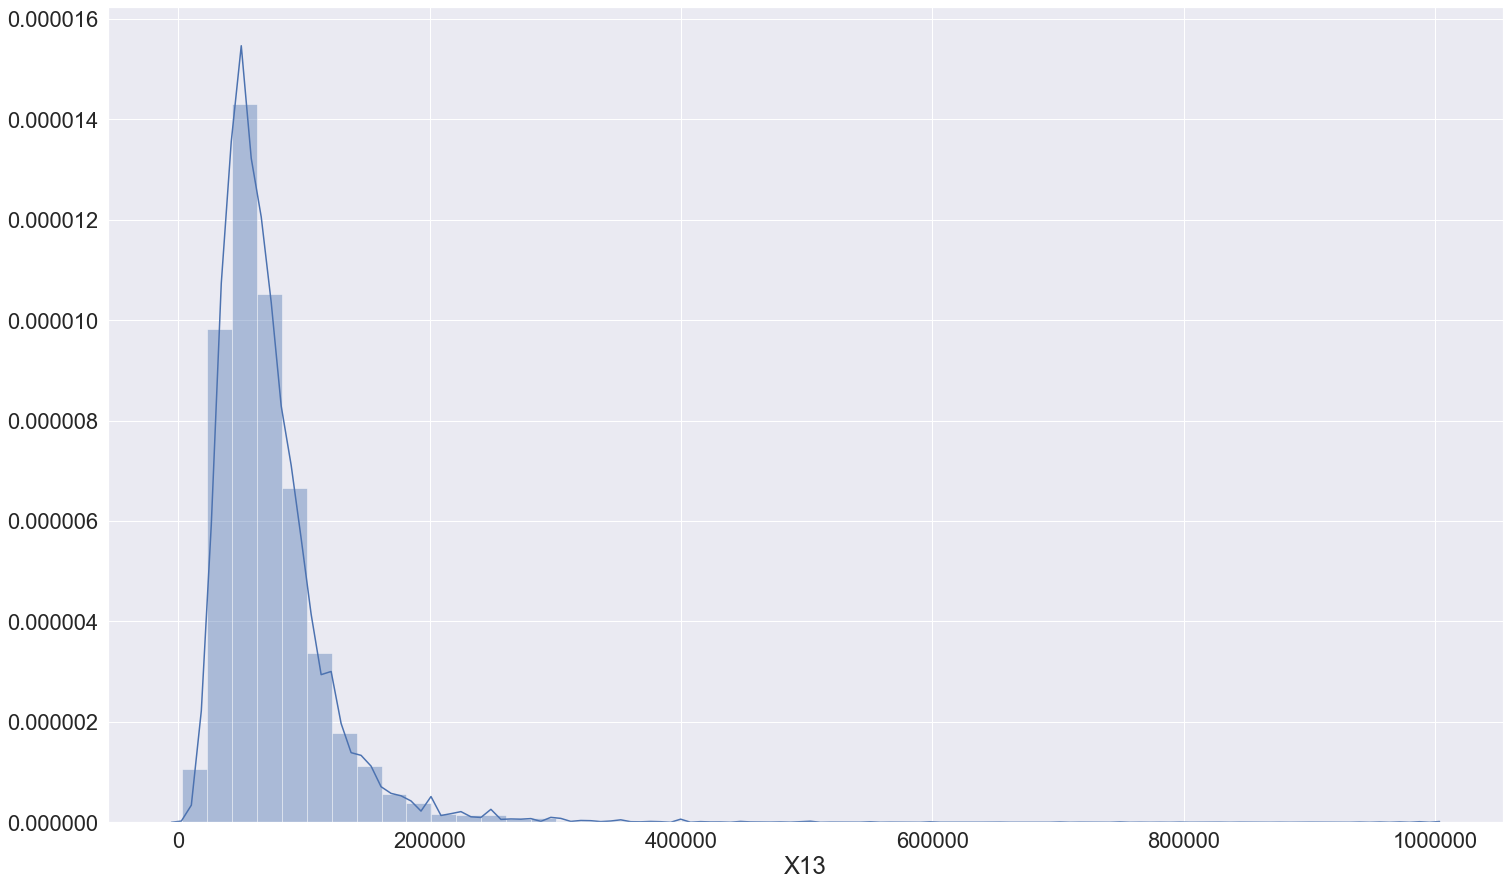

In [63]:
sns.distplot(loan.X13[(loan.X13>0) & (loan.X13<1000000)])

after log transformation

In [64]:
loan['logX13']=np.log1p(loan.X13)

In [65]:
loan_heldout['logX13']=np.log1p(loan_heldout.X13)

In [66]:
loan['logX13'].isnull().sum()

43990

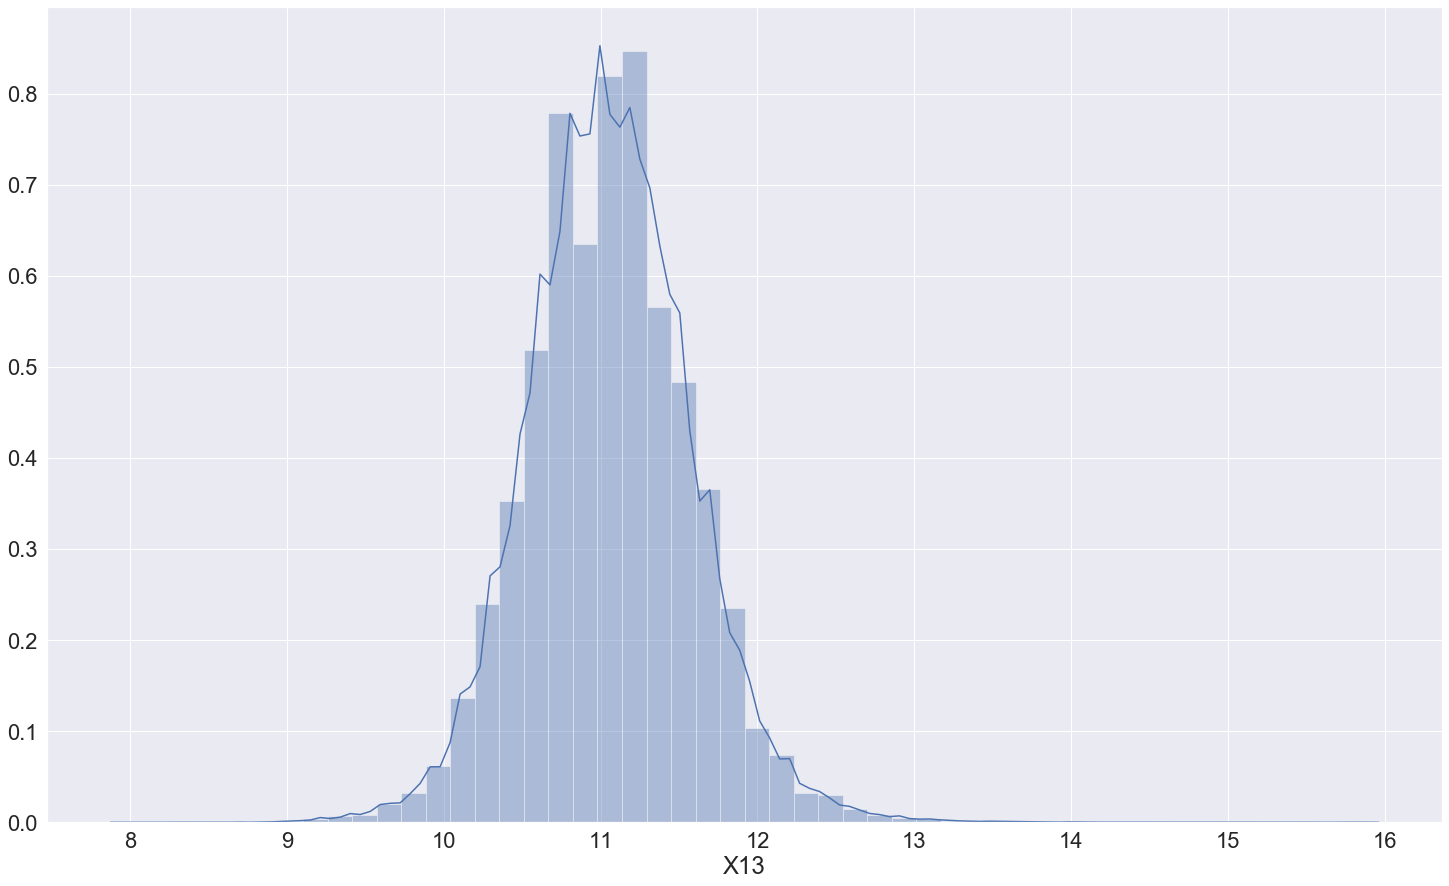

In [67]:
sns.distplot(np.log1p(loan.X13[(loan.X13>0)]))

using mice to impute income data

In [68]:
annual_income=loan[['X4','X21','X29','X31','logX13']]
annual_income

,X4,X21,X29,X31,logX13
0,25000.0,19.48,28854.0,42.0,11.350418
1,7000.0,14.29,33623.0,7.0,11.082158
2,25000.0,10.50,19878.0,17.0,11.156265
3,1200.0,5.47,2584.0,31.0,10.896758
4,10800.0,11.63,3511.0,40.0,10.373522
...,...,...,...,...,...
399995,10000.0,21.51,10268.0,20.0,10.819798
399996,13150.0,29.76,8931.0,21.0,10.308986
399997,20000.0,24.13,28976.0,48.0,11.502885
399998,18475.0,31.43,11982.0,31.0,10.645449


In [69]:
MICE_imputer = IterativeImputer()
MICE_imputer.fit(annual_income)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, tol=0.001, verbose=0)

In [70]:
test=MICE_imputer.transform(annual_income)

In [71]:
annual_income_fitted=pd.DataFrame(test,columns=['X4','X21','X29','X31','logX13'])

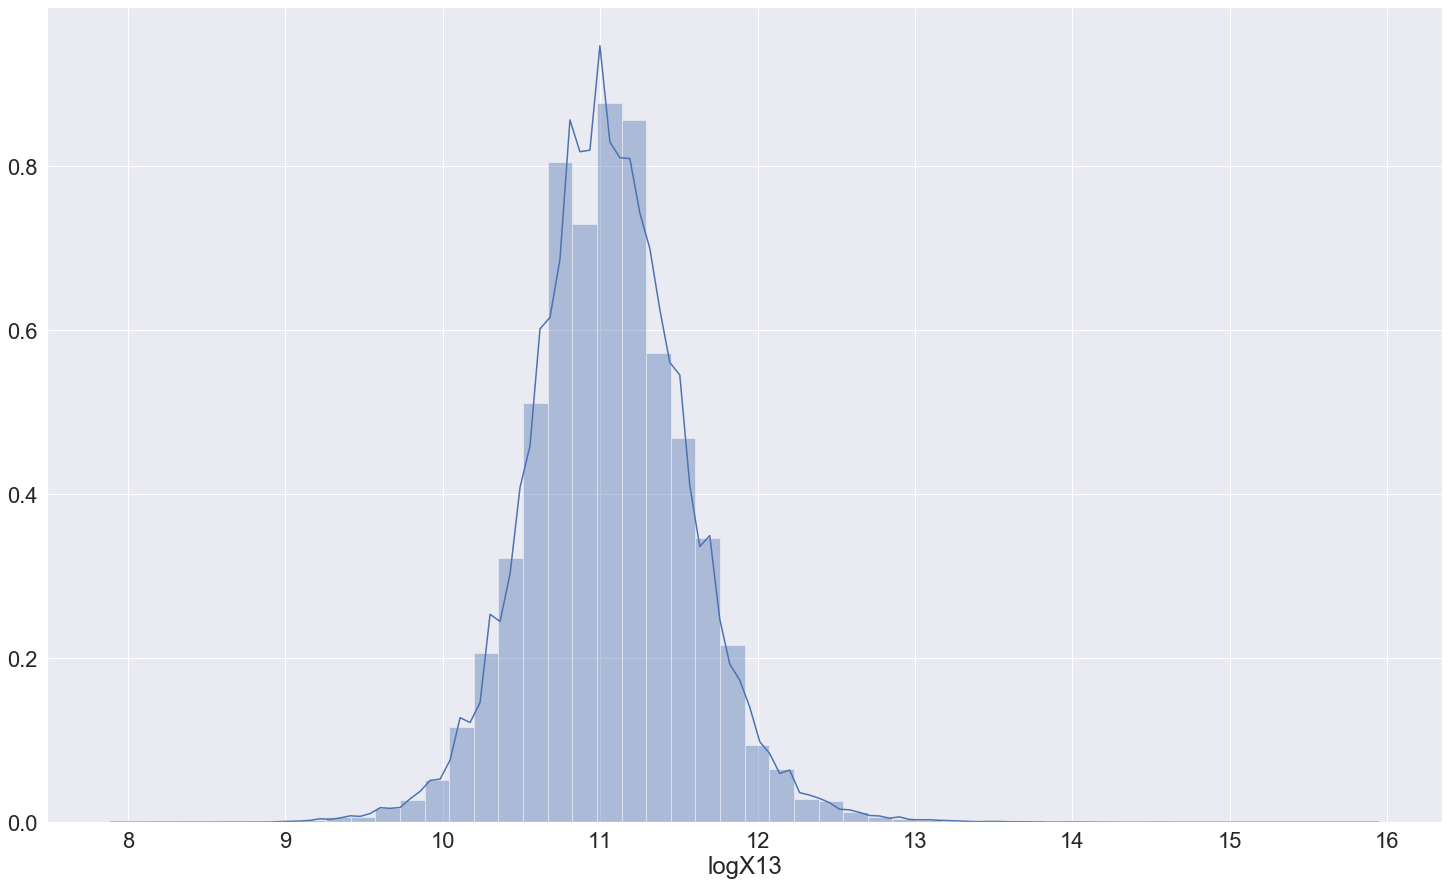

In [72]:
sns.distplot(annual_income_fitted.logX13)

In [73]:
loan['logX13']=annual_income_fitted['logX13'].values

In [133]:
loan=loan.reset_index()

In [134]:
loan[loan['X13'].isnull()].index

Int64Index([206191, 206192, 206196, 206197, 206201, 206203, 206217, 206219,
            206221, 206222,
            ...
            287030, 287037, 287043, 287046, 287063, 287068, 287078, 287095,
            287098, 287115],
           dtype='int64', length=12422)

In [135]:
np.exp(annual_income_fitted[annual_income_fitted.index.isin(loan[loan['X13'].isnull()].index)].logX13)

206191     52593.606873
206192    110947.215313
206196     80707.359709
206197     85016.844350
206201     60022.578620
              ...      
287068     68648.660048
287078     67619.740044
287095     45331.066090
287098     79709.804743
287115     94269.564080
Name: logX13, Length: 12422, dtype: float64

In [136]:
loan['X13'][loan['X13'].isnull()]=np.exp(annual_income_fitted[annual_income_fitted.index.isin(loan['X13'].isnull().index)].logX13)

impute X30

In [75]:
loan.X30.fillna(loan.X30.median(),inplace=True)

In [39]:
loan_heldout.X30.fillna(loan_heldout.X30.median(),inplace=True)

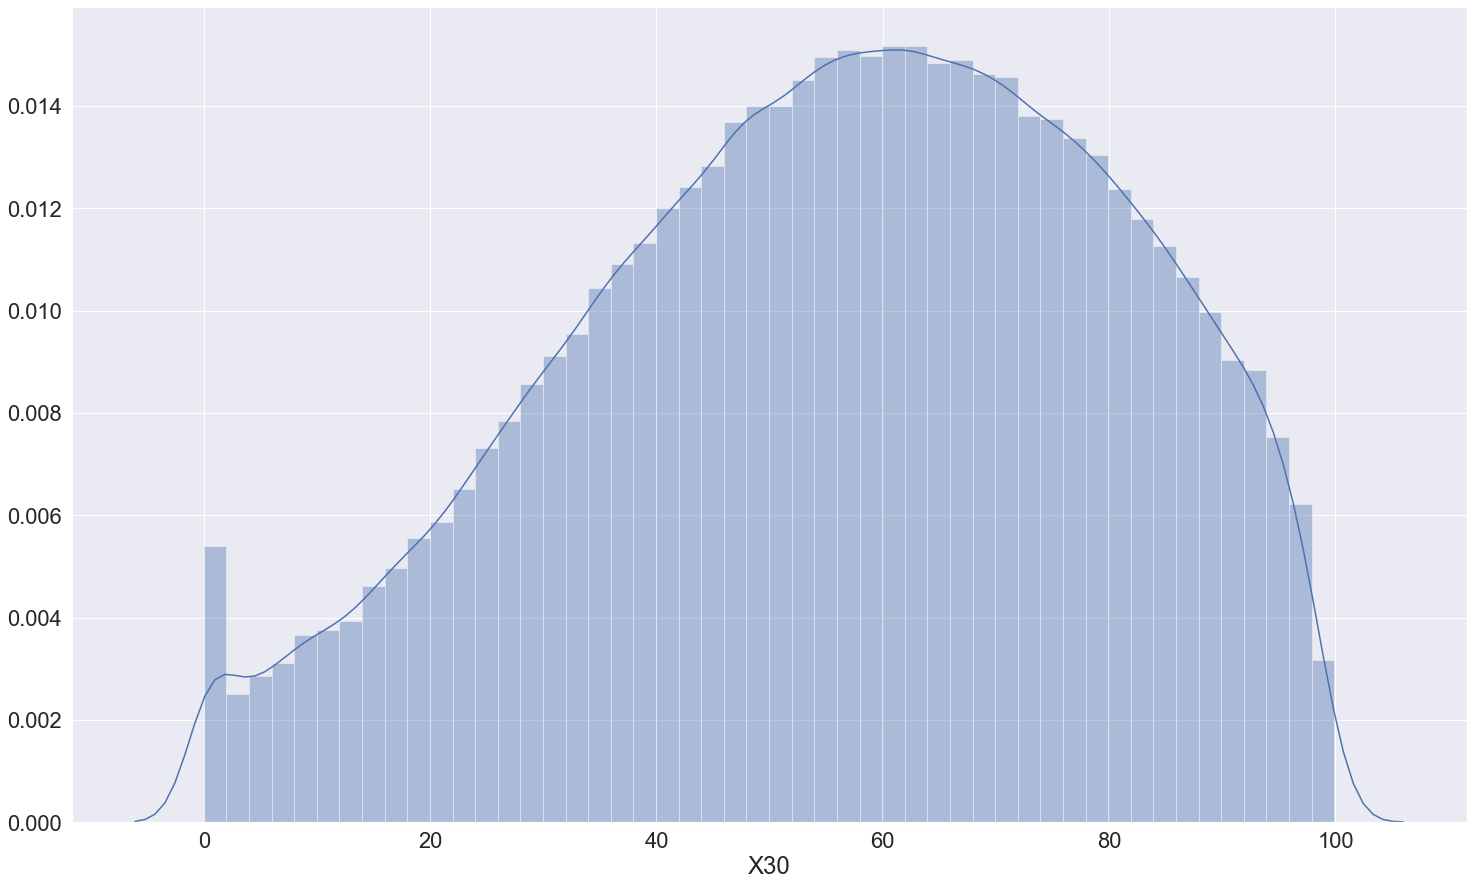

In [76]:
sns.distplot(loan.X30[loan.X30<100])

try to summarize X10

In [27]:
loan.X10[loan.X10.notnull()]

1                                       CNN
2                            Web Programmer
3                    city of beaumont texas
4                      State Farm Insurance
5                                 Arkwright
                        ...                
399995             Administrative Assistant
399996                               helper
399997               Facility Administrator
399998    Senior Creative Designer/Ad Sales
399999                          Electrician
Name: X10, Length: 270050, dtype: object

In [29]:
text=loan.X10[loan.X10.notnull()].values
text
#text=word_tokenize(text)

array(['CNN', 'Web Programmer', 'city of beaumont texas', ...,
       'Facility Administrator', 'Senior Creative Designer/Ad Sales',
       'Electrician'], dtype=object)

In [30]:
Counter(pd.Series(text)).most_common(11)

[('Teacher', 3024),
 ('Manager', 2411),
 ('Registered Nurse', 1307),
 ('RN', 1216),
 ('Supervisor', 1086),
 ('Sales', 906),
 ('Project Manager', 903),
 ('Office Manager', 772),
 ('Owner', 747),
 ('manager', 738),
 ('Driver', 725)]

In [11]:
from wordcloud import WordCloud

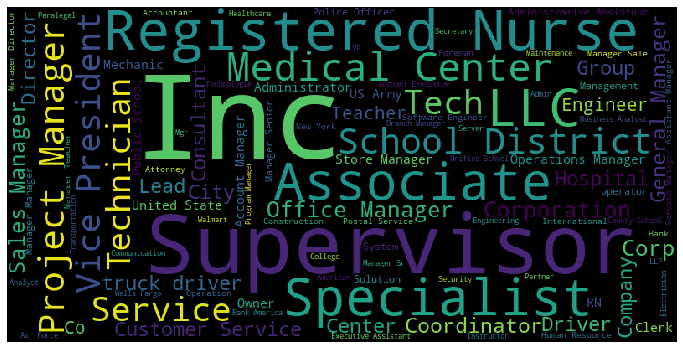

In [35]:
wordcloud2 = WordCloud(width=800,height=400,max_words=100 ).generate(' '.join(text))
plt.figure(figsize=(12,9))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [438]:
jobtitle=" ".join(loan[loan['X10'].notnull()]['X10']).lower().split()
no_stops = [t for t in jobtitle if t not in stopwords.words('english')]

In [439]:
Counter(pd.Series(no_stops)).most_common(11)

[('manager', 32782),
 ('director', 8665),
 ('sales', 7918),
 ('assistant', 7754),
 ('inc.', 6843),
 ('inc', 6763),
 ('service', 6587),
 ('supervisor', 6226),
 ('teacher', 6209),
 ('senior', 6198),
 ('engineer', 6132)]

create a new feature based on how many months that one person opened the credit line -> data is too messy and gave up

In [41]:
# dateparse = lambda x: pd.datetime.strptime(x,'%b-%y')
# loan['X15']=loan['X15'].apply(dateparse).dt.to_period('M')
# loan['X23']=loan['X23'].apply(dateparse).dt.to_period('M')

In [42]:
# loan['credit_month']=(loan['X15']-loan['X23']).apply(attrgetter('n'))

In [ ]:
# dateparse = lambda x: pd.datetime.strptime(x,'%b-%y')
# loan_heldout['X15']=loan_heldout['X15'].apply(dateparse).dt.to_period('M')
# loan_heldout['X23']=loan_heldout['X23'].apply(dateparse).dt.to_period('M')
# loan_heldout['credit_month']=(loan_heldout['X15']-loan_heldout['X23']).apply(attrgetter('n'))

impute X11 with the most frequent and create new feature by regrouping the levels

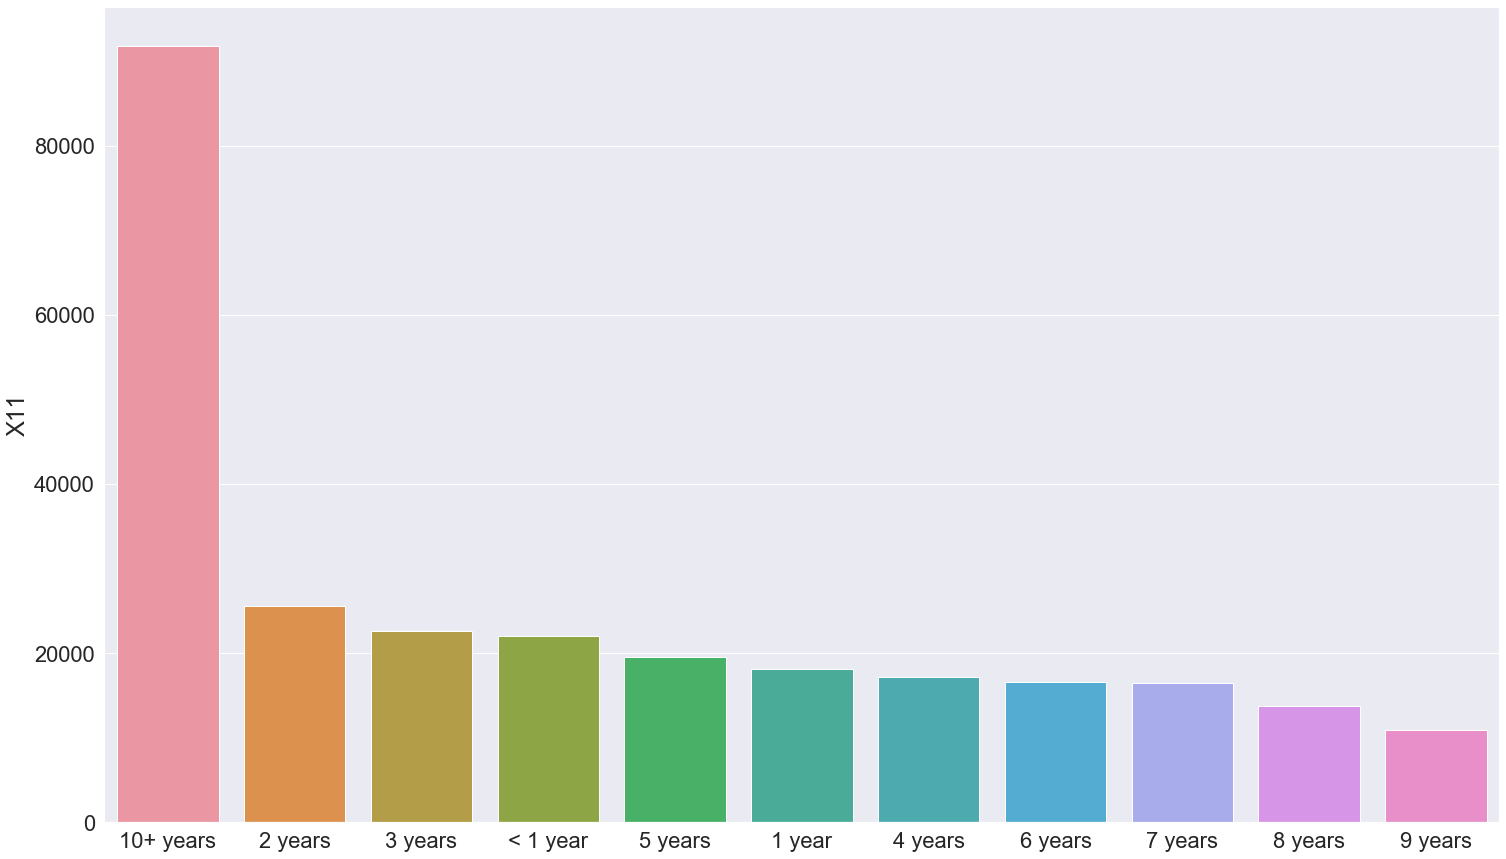

In [77]:
df=pd.DataFrame(loan['X11'].value_counts())
sns.barplot(x=df.index,y=df['X11'])

In [78]:
loan.X11.fillna(loan.X11.mode()[0],inplace=True)

In [79]:
loan_heldout.X11.fillna(loan_heldout.X11.mode()[0],inplace=True)

In [80]:
loan['X11_new']=loan.X11.replace({'2 years':'under 5 years','3 years':'under 5 years',
 '< 1 year':'under 5 years','1 year':'under 5 years',
 '4 years':'under 5 years','5 years':'5-10 years',
 '6 years':'5-10 years','7 years':'5-10 years',
 '8 years':'5-10 years','9 years':'5-10 years'})

In [81]:
loan_heldout['X11_new']=loan_heldout.X11.replace({'2 years':'under 5 years','3 years':'under 5 years',
 '< 1 year':'under 5 years','1 year':'under 5 years',
 '4 years':'under 5 years','5 years':'5-10 years',
 '6 years':'5-10 years','7 years':'5-10 years',
 '8 years':'5-10 years','9 years':'5-10 years'})

In [82]:
loan['X11_new'].unique()

array(['under 5 years', '10+ years', '5-10 years'], dtype=object)

In [83]:
loan_heldout['X11_new'].unique()

array(['10+ years', '5-10 years', 'under 5 years'], dtype=object)

X18 is similar with X17 -> drop X18

In [87]:
loan.to_csv('loan_visulization.csv')

### select feature

drop=['X2','X3','X5','X6','X8','X10','X15','X18','X19','X23','X26','X27','public']
X4,X5,X6-choose one
X8,X9-choose one
X10-jobtitle
X14-reenginer
X15-date not sure
X16-deleted already
X19,X20-choose one
X23-date
X26,X28 correlated -drop X26
X27,X31-very alike

In [144]:
df_train=copy.deepcopy(loan)

In [89]:
df_holdout=copy.deepcopy(loan_heldout)

In [145]:
drop_col=['X2','X3','X5','X6','X10','X11','X15','X18','X19','X23','X26','public']  # for visulization
df_train.drop(drop_col,axis=1,inplace=True)

In [90]:
drop_col=['X2','X3','X5','X6','X8','X10','X11','X13','X15','X18','X19','X23','X26','X27','public']
df_train.drop(drop_col,axis=1,inplace=True)

In [91]:
drop_col=['X2','X3','X5','X6','X8','X10','X11','X13','X15','X18','X19','X23','X26','X27','public']
df_holdout.drop(drop_col,axis=1,inplace=True)

In [139]:
df_train.isnull().sum()

index          0
X1             0
X4             0
X7             0
X8             0
X9             0
X12            0
X13            0
X14            0
X17            0
X20            0
X21            0
X22            0
X24            0
X25            0
X27            0
X28            0
X29            0
X30            0
X31            0
X32            0
delinquency    0
logX13         0
X11_new        0
dtype: int64

In [146]:
df_train.to_csv('loan_visulization.csv')

In [53]:
df_holdout.isnull().sum()

X1             80000
X4                 0
X7                 0
X9                 0
X12                0
X14                0
X17                0
X20                0
X21                0
X22                0
X24                0
X25                0
X28                0
X29                0
X30                0
X31                0
X32                0
delinquency        0
logX13             0
X11_new            0
dtype: int64

In [54]:
df_train

,X1,X4,X7,X9,X12,X14,X17,X20,X21,X22,X24,X25,X28,X29,X30,X31,X32,delinquency,logX13,X11_new
0,11.89,25000.0,36 months,B4,RENT,VERIFIED - income,debt_consolidation,CA,19.48,0.0,0.0,0.0,0.0,28854.0,52.1,42.0,f,0,11.350418,under 5 years
1,10.71,7000.0,36 months,B5,RENT,not verified,credit_card,NY,14.29,0.0,0.0,0.0,0.0,33623.0,76.7,7.0,f,0,11.082158,under 5 years
2,16.99,25000.0,36 months,D3,RENT,VERIFIED - income,debt_consolidation,NY,10.50,0.0,0.0,41.0,0.0,19878.0,66.3,17.0,f,1,11.156265,under 5 years
3,13.11,1200.0,36 months,C2,OWN,not verified,debt_consolidation,TX,5.47,0.0,0.0,64.0,0.0,2584.0,40.4,31.0,f,1,10.896758,10+ years
4,13.57,10800.0,36 months,C3,RENT,not verified,debt_consolidation,CT,11.63,0.0,1.0,58.0,0.0,3511.0,25.6,40.0,f,1,10.373522,5-10 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,12.99,10000.0,60 months,C1,RENT,VERIFIED - income source,credit_card,FL,21.51,0.0,0.0,26.0,0.0,10268.0,76.1,20.0,w,1,10.819798,5-10 years
399996,16.29,13150.0,36 months,D2,OWN,VERIFIED - income,debt_consolidation,TX,29.76,0.0,0.0,38.0,0.0,8931.0,37.8,21.0,f,1,10.308986,under 5 years
399997,10.99,20000.0,60 months,B3,MORTGAGE,VERIFIED - income source,credit_card,TX,24.13,0.0,0.0,63.0,0.0,28976.0,69.3,48.0,w,1,11.502885,under 5 years
399998,17.57,18475.0,60 months,D4,OWN,VERIFIED - income source,debt_consolidation,TX,31.43,0.0,0.0,0.0,0.0,11982.0,39.0,31.0,f,0,10.645449,10+ years


In [56]:
sns.set(rc={'figure.figsize':(25,15)},font_scale=2)

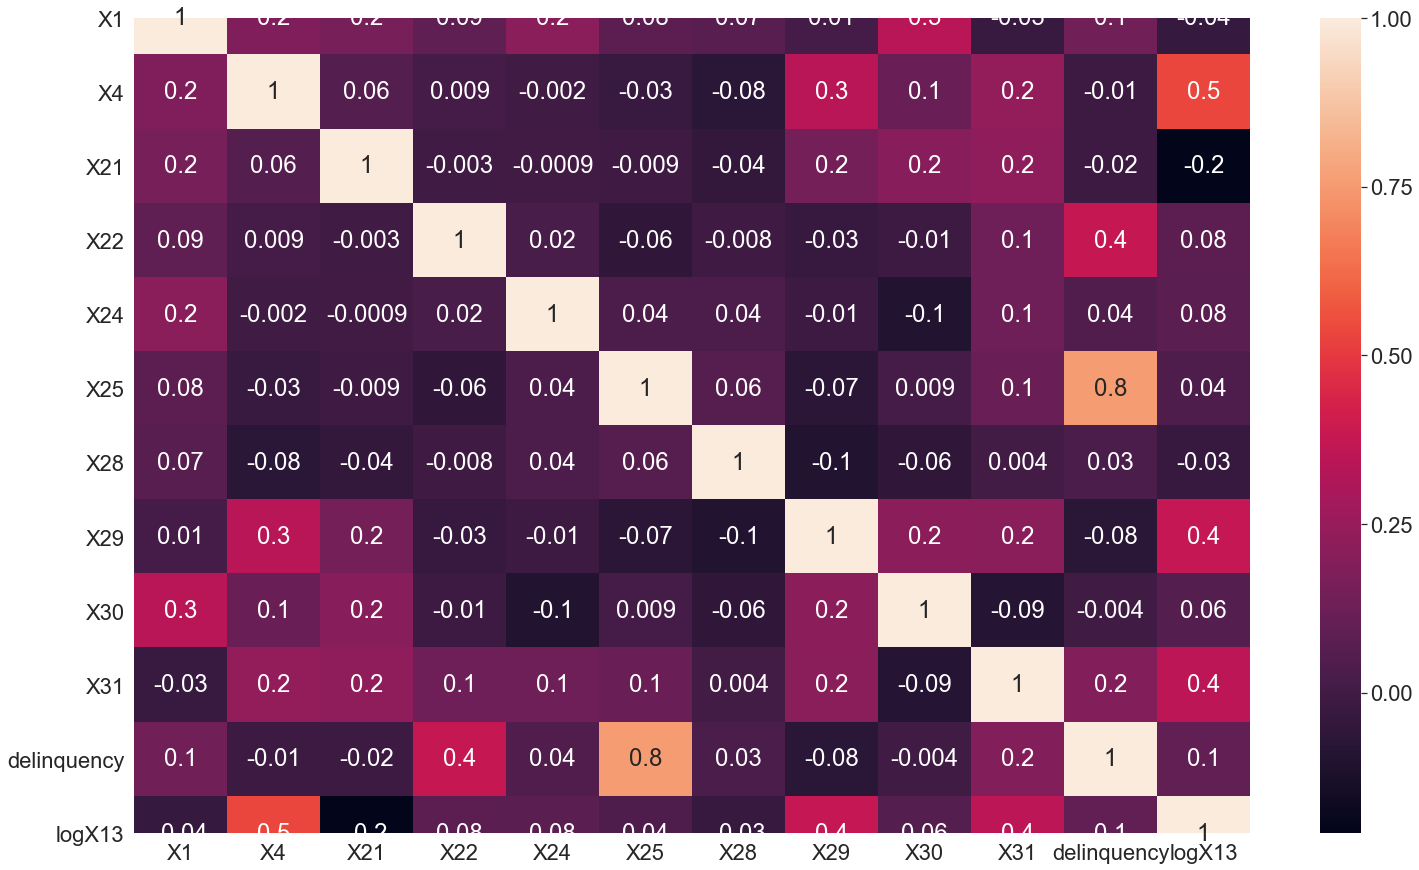

In [57]:
corr=df_train.corr()
sns.heatmap(corr,annot=True,fmt='.1g')

### prepare train and holdout set

In [58]:
# dummy_cols =['X7', 'X12', 'X14', 'X17', 'X20', 'X32', 'X11_new']
# df_train=pd.get_dummies(df_train,drop_first=True,columns=dummy_cols)
# df_train

df_all=pd.concat([df_train,df_holdout])

df_all=pd.get_dummies(df_all,drop_first=True)
df_all

,X1,X4,X21,X22,X24,X25,X28,X29,X30,X31,delinquency,logX13,X7_ 60 months,X9_A2,X9_A3,X9_A4,X9_A5,X9_B1,X9_B2,X9_B3,X9_B4,X9_B5,X9_C1,X9_C2,X9_C3,X9_C4,X9_C5,X9_D1,X9_D2,X9_D3,X9_D4,X9_D5,X9_E1,X9_E2,X9_E3,X9_E4,X9_E5,X9_F1,X9_F2,X9_F3,X9_F4,X9_F5,X9_G1,X9_G2,X9_G3,X9_G4,X9_G5,X12_NONE,X12_OTHER,X12_OWN,...,X20_AZ,X20_CA,X20_CO,X20_CT,X20_DC,X20_DE,X20_FL,X20_GA,X20_HI,X20_IA,X20_ID,X20_IL,X20_IN,X20_KS,X20_KY,X20_LA,X20_MA,X20_MD,X20_ME,X20_MI,X20_MN,X20_MO,X20_MS,X20_MT,X20_NC,X20_NE,X20_NH,X20_NJ,X20_NM,X20_NV,X20_NY,X20_OH,X20_OK,X20_OR,X20_PA,X20_RI,X20_SC,X20_SD,X20_TN,X20_TX,X20_UT,X20_VA,X20_VT,X20_WA,X20_WI,X20_WV,X20_WY,X32_w,X11_new_5-10 years,X11_new_under 5 years
0,11.89,25000.0,19.48,0.0,0.0,0.0,0.0,28854.0,52.1,42.0,0,11.350418,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,10.71,7000.0,14.29,0.0,0.0,0.0,0.0,33623.0,76.7,7.0,0,11.082158,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,16.99,25000.0,10.50,0.0,0.0,41.0,0.0,19878.0,66.3,17.0,1,11.156265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,13.11,1200.0,5.47,0.0,0.0,64.0,0.0,2584.0,40.4,31.0,1,10.896758,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,13.57,10800.0,11.63,0.0,1.0,58.0,0.0,3511.0,25.6,40.0,1,10.373522,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,NaN,6400.0,15.74,0.0,0.0,0.0,0.0,7185.0,47.9,15.0,0,10.819798,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
79996,NaN,30000.0,19.28,0.0,0.0,0.0,0.0,25151.0,51.3,38.0,0,11.429555,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
79997,NaN,17600.0,17.50,0.0,0.0,32.0,0.0,12161.0,37.1,36.0,1,11.156265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
79998,NaN,2500.0,16.52,0.0,0.0,0.0,0.0,13031.0,76.7,23.0,0,11.289794,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
len_train=len(df_train)
len_train

287123

In [60]:
df_train=df_all.iloc[:len_train,:]
df_holdout=df_all.iloc[len_train:,:]

In [61]:
len(df_train)

287123

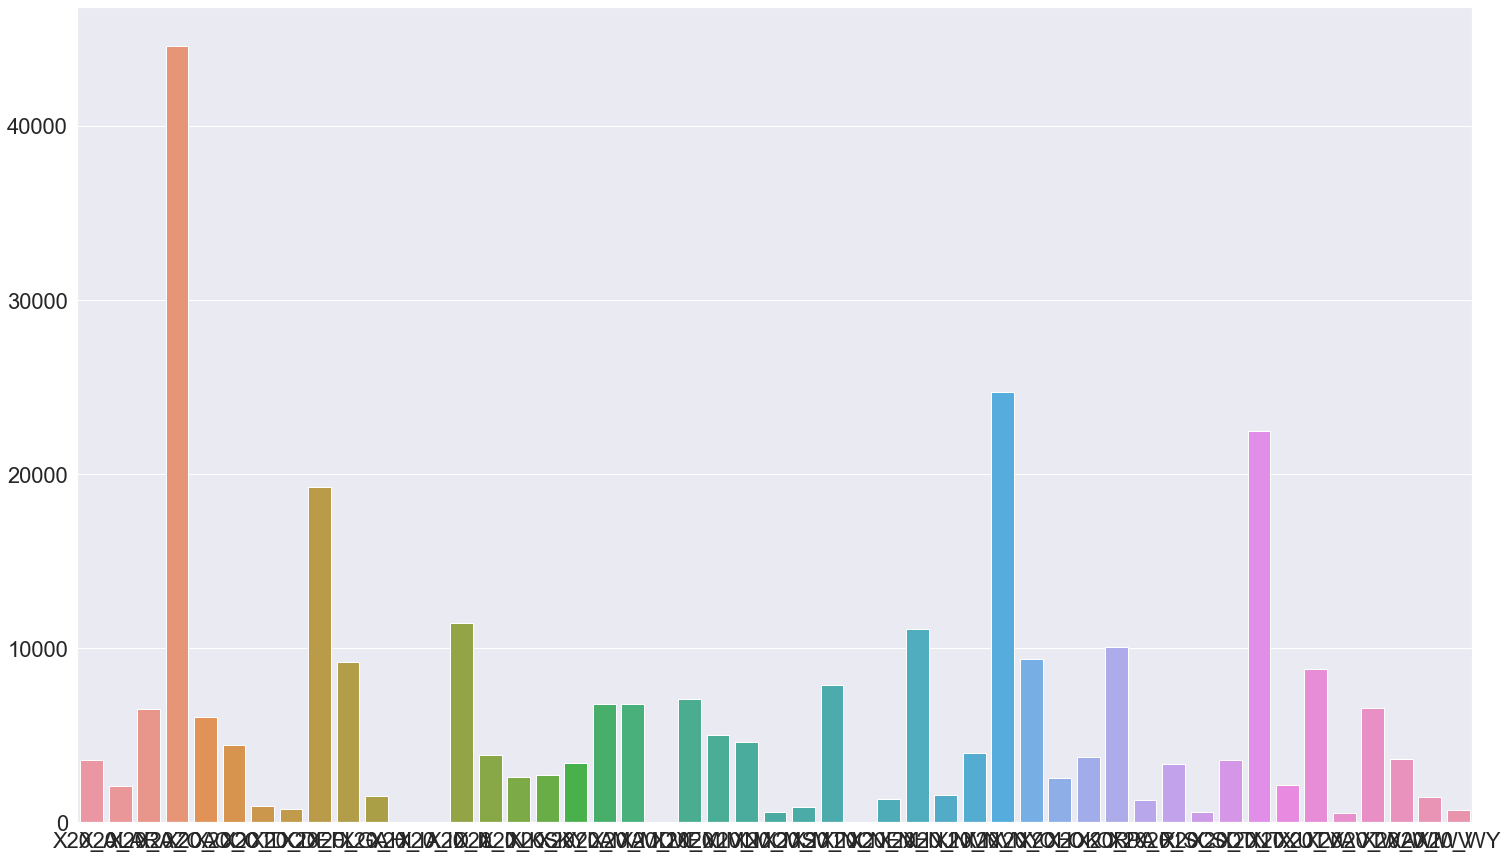

In [62]:
filter_column=[col for col in df_train.columns if col.startswith('X20')]
sns.barplot(filter_column,df_train[filter_column].sum())
mask=df_train[filter_column].sum()<10000
df_train.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)
df_holdout.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)

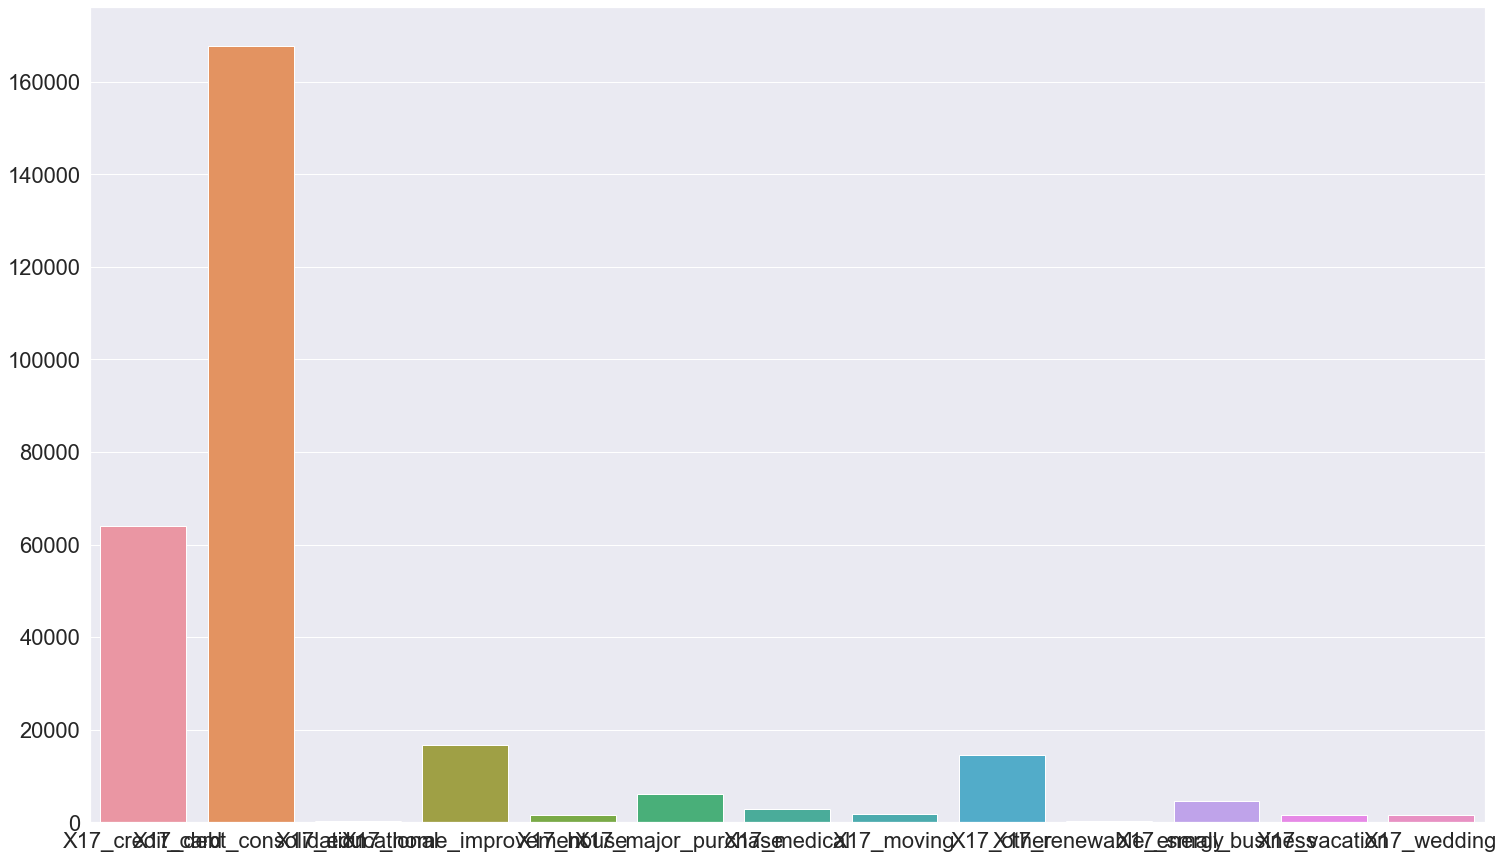

In [63]:
filter_column=[col for col in df_train.columns if col.startswith('X17')]
sns.barplot(filter_column,df_train[filter_column].sum())
mask=df_train[filter_column].sum()<50000
df_train.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)
df_holdout.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)

In [88]:
# filter_column=[col for col in df_holdout.columns if col.startswith('X20')]
# mask=df_holdout[filter_column].sum()<10000
# df_holdout.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)

# filter_column=[col for col in df_holdout.columns if col.startswith('X17')]
# mask=df_holdout[filter_column].sum()<50000
# df_holdout.drop(mask[mask==True].index.tolist(),axis=1,inplace=True)

Scale the feature

In [64]:
X_temp=df_train.drop('X1',axis=1)
y=df_train['X1'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X=pd.DataFrame(X_values,columns=X_temp.columns)
X['X9']=loan.X9.values

In [65]:
X_temp_heldout=df_holdout.drop('X1',axis=1)
scaler=MinMaxScaler()
X_values_heldout=scaler.fit_transform(X_temp_heldout)
X_heldout=pd.DataFrame(X_values_heldout,columns=X_temp_heldout.columns)
X_heldout['X9']=loan_heldout.X9.values

In [66]:
X

,X4,X21,X22,X24,X25,X28,X29,X30,X31,delinquency,logX13,X7_ 60 months,X9_A2,X9_A3,X9_A4,X9_A5,X9_B1,X9_B2,X9_B3,X9_B4,X9_B5,X9_C1,X9_C2,X9_C3,X9_C4,X9_C5,X9_D1,X9_D2,X9_D3,X9_D4,X9_D5,X9_E1,X9_E2,X9_E3,X9_E4,X9_E5,X9_F1,X9_F2,X9_F3,X9_F4,X9_F5,X9_G1,X9_G2,X9_G3,X9_G4,X9_G5,X12_NONE,X12_OTHER,X12_OWN,X12_RENT,X12_UNKNOWN,X14_VERIFIED - income source,X14_not verified,X17_credit_card,X17_debt_consolidation,X20_CA,X20_FL,X20_IL,X20_NJ,X20_NY,X20_PA,X20_TX,X32_w,X11_new_5-10 years,X11_new_under 5 years,X9
0,0.710145,0.487122,0.0,0.000,0.000000,0.0,0.011232,0.058388,0.344828,0.0,0.427382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B4
1,0.188406,0.357339,0.0,0.000,0.000000,0.0,0.013088,0.085958,0.043103,0.0,0.393094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,B5
2,0.710145,0.262566,0.0,0.000,0.218085,0.0,0.007738,0.074302,0.129310,1.0,0.402566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,D3
3,0.020290,0.136784,0.0,0.000,0.340426,0.0,0.001006,0.045276,0.250000,1.0,0.369397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,C2
4,0.298551,0.290823,0.0,0.125,0.308511,0.0,0.001367,0.028690,0.327586,1.0,0.302519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287118,0.275362,0.537884,0.0,0.000,0.138298,0.0,0.003997,0.085285,0.155172,1.0,0.359560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,C1
287119,0.366667,0.744186,0.0,0.000,0.202128,0.0,0.003476,0.042362,0.163793,1.0,0.294270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,D2
287120,0.565217,0.603401,0.0,0.000,0.335106,0.0,0.011279,0.077664,0.396552,1.0,0.446870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,B3
287121,0.521014,0.785946,0.0,0.000,0.000000,0.0,0.004664,0.043707,0.250000,0.0,0.337276,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,D4


In [67]:
X_heldout

,X4,X21,X22,X24,X25,X28,X29,X30,X31,delinquency,logX13,X7_ 60 months,X9_A2,X9_A3,X9_A4,X9_A5,X9_B1,X9_B2,X9_B3,X9_B4,X9_B5,X9_C1,X9_C2,X9_C3,X9_C4,X9_C5,X9_D1,X9_D2,X9_D3,X9_D4,X9_D5,X9_E1,X9_E2,X9_E3,X9_E4,X9_E5,X9_F1,X9_F2,X9_F3,X9_F4,X9_F5,X9_G1,X9_G2,X9_G3,X9_G4,X9_G5,X12_NONE,X12_OTHER,X12_OWN,X12_RENT,X12_UNKNOWN,X14_VERIFIED - income source,X14_not verified,X17_credit_card,X17_debt_consolidation,X20_CA,X20_FL,X20_IL,X20_NJ,X20_NY,X20_PA,X20_TX,X32_w,X11_new_5-10 years,X11_new_under 5 years,X9
0,0.147059,0.707927,0.0,0.125,0.147727,0.000000,0.019026,0.349404,0.183544,1.0,0.358348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C5
1,0.676471,0.400850,0.0,0.125,0.000000,0.000000,0.016287,0.141928,0.202532,0.0,0.422525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,A1
2,1.000000,0.812453,0.0,0.000,0.000000,0.000000,0.024713,0.270314,0.183544,0.0,0.389402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,C2
3,0.264706,0.824206,0.0,0.125,0.000000,0.045455,0.009183,0.237270,0.107595,0.0,0.250140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,D1
4,0.676471,0.775944,0.0,0.000,0.272727,0.000000,0.030504,0.223727,0.246835,1.0,0.383908,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.158824,0.393598,0.0,0.000,0.000000,0.000000,0.006883,0.259480,0.069620,0.0,0.317688,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,A2
79996,0.852941,0.482121,0.0,0.000,0.000000,0.000000,0.024094,0.277898,0.215190,0.0,0.398320,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,E2
79997,0.488235,0.437609,0.0,0.000,0.181818,0.000000,0.011650,0.200975,0.202532,1.0,0.362181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,D4
79998,0.044118,0.413103,0.0,0.000,0.000000,0.000000,0.012483,0.415493,0.120253,0.0,0.379839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C2


In [68]:
zero_columns=set(X.columns)-(set(X_heldout.columns))
zero_columns

set()

### train test split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [70]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

### model selection - using by subgrade models

Linear regression

one model

In [332]:
# create a new object of Linear Regression class
# model1 = LinearRegression()
# model1.fit(X_train,y_train)
# ypredict1_train=model1.predict(X_train)
# ypredict1_test=model1.predict(X_test)

In [333]:
# mean_squared_error(y_train,ypredict1_train)**0.5

In [334]:
# mean_squared_error(y_test,ypredict1_test)**0.5

By subgrade Models

In [71]:
loan_subgrade=loan.X9.unique()
y_predict1_train=np.zeros_like(y_train)
y_predict1_test=np.zeros_like(y_test)
models1=[]
modelsname1=[]
for grade in loan_subgrade:
    model1 = LinearRegression()
    index_train=X_train[X_train.X9==grade].index
    index_test=X_test[X_test.X9==grade].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('X9',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('X9',axis=1)
    model1.fit(df_x_train,y_2)
    models1.append(model1)
    modelsname1.append(grade)
    y_predict1_train[index_train]=model1.predict(df_x_train)
    y_predict1_test[index_test]=model1.predict(df_x_test)

models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [72]:
mean_squared_error(y_train,y_predict1_train)**0.5

0.7920004305926912

In [73]:
mean_squared_error(y_test,y_predict1_test)**0.5

0.8006012473267893

Random Forest

one model

In [339]:
# model2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
#                       max_features=0.75, max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=2, min_samples_split=5,
#                       min_weight_fraction_leaf=0.0, n_estimators=300,
#                       n_jobs=3, oob_score=True, random_state=1, verbose=0,
#                       warm_start=False)
# model2.fit(X_train,y_train)
# ypredict2_train=model2.predict(X_train)
# ypredict2_test=model2.predict(X_test)

In [340]:
# mean_squared_error(y_train,ypredict2_train)**0.5

In [341]:
# mean_squared_error(y_test,ypredict2_test)**0.5

By subgrade Models

In [74]:
loan_subgrade=loan.X9.unique()
y_predict2_train=np.zeros_like(y_train)
y_predict2_test=np.zeros_like(y_test)
models2=[]
modelsname2=[]
for grade in loan_subgrade:
    model2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)
    index_train=X_train[X_train.X9==grade].index
    index_test=X_test[X_test.X9==grade].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('X9',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('X9',axis=1)
    model2.fit(df_x_train,y_2)
    models2.append(model2)
    modelsname2.append(grade)
    y_predict2_train[index_train]=model2.predict(df_x_train)
    y_predict2_test[index_test]=model2.predict(df_x_test)
models_rf={mn:m for mn,m in zip(modelsname2,models2)}

In [76]:
mean_squared_error(y_train,y_predict2_train)**0.5

0.3930415856983747

In [77]:
mean_squared_error(y_test,y_predict2_test)**0.5

0.7744497643757773

In [358]:
y_predict2_heldout=np.zeros(len(X_heldout))
for grade in loan_subgrade_heldout:
    index_heldout=X_heldout[X_heldout.X9==grade].index
    df_x_heldout=X_heldout[X_heldout.index.isin(index_heldout)].drop('X9',axis=1)
    model2=models_rf[grade]
    y_predict2_heldout[index_heldout]=model2.predict(df_x_heldout)

check feature importance and reselect features if needed

In [78]:
importances_rf=pd.Series(model2.feature_importances_,index=X_train.drop('X9',axis=1).columns).sort_values(ascending=False)

In [114]:
importances_rf[0:30]

X30                             0.218090
X4                              0.131374
X29                             0.098425
X21                             0.097216
logX13                          0.076369
X31                             0.075314
X25                             0.068328
X7_ 60 months                   0.038709
X24                             0.029690
X32_w                           0.026317
X11_new_under 5 years           0.024907
X14_not verified                0.014659
X28                             0.014119
X12_RENT                        0.012618
X22                             0.012247
X20_CA                          0.009410
X14_VERIFIED - income source    0.008923
X17_debt_consolidation          0.007815
X11_new_5-10 years              0.007330
X17_credit_card                 0.005824
X20_TX                          0.005568
delinquency                     0.004204
X20_NY                          0.004131
X12_UNKNOWN                     0.002291
X20_PA          

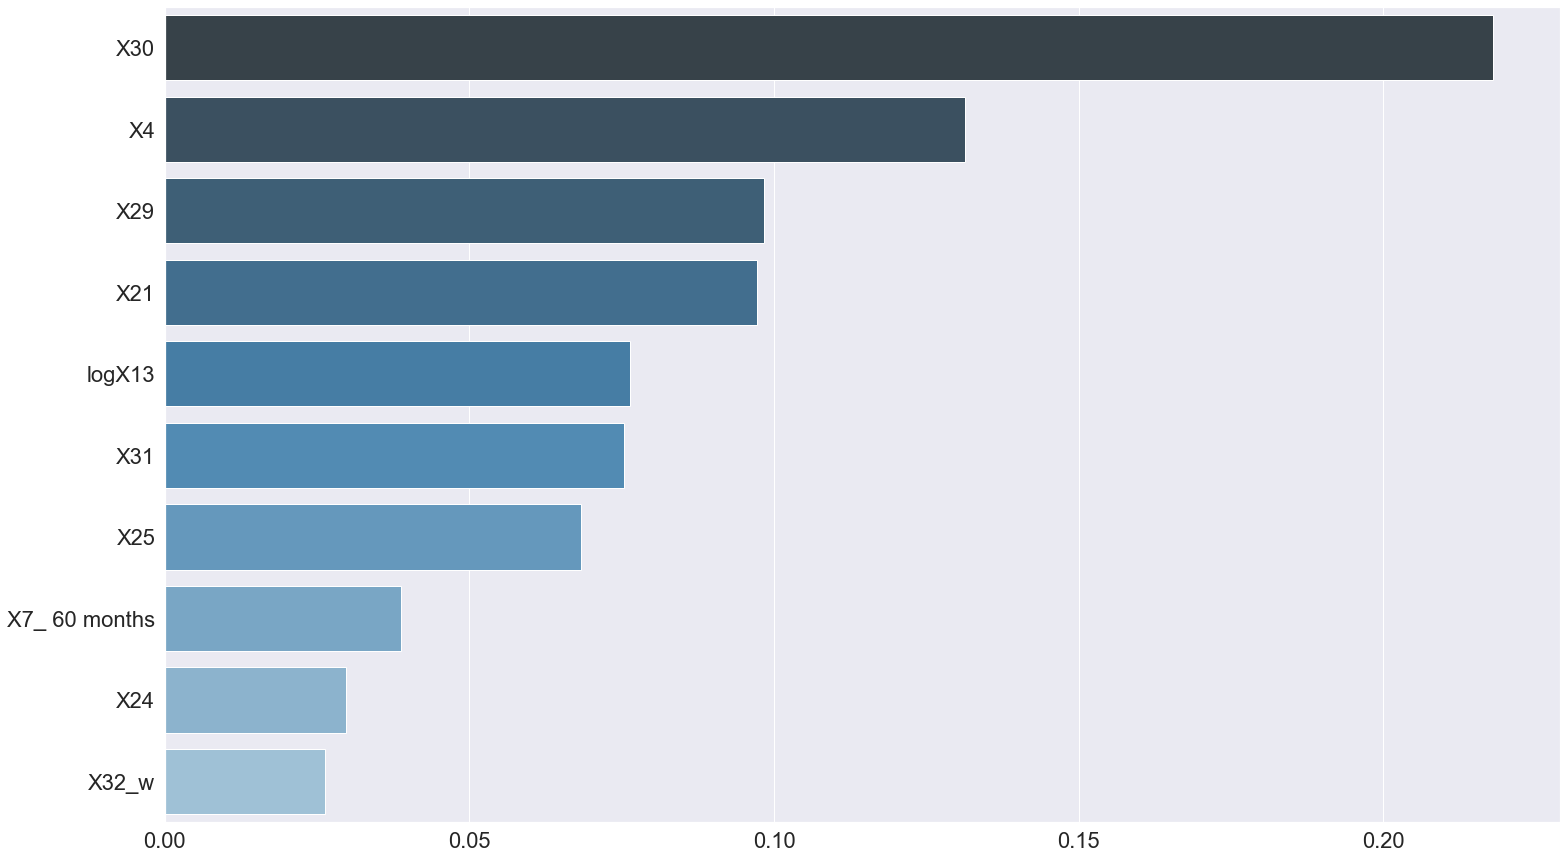

In [118]:
sns.barplot(y=importances_rf[0:10].index,x=importances_rf[0:10],palette="Blues_d")

Support Vector Regressor

one model

In [ ]:
# model3 = SVR(kernel='rbf')
# model3.fit(X_train,y_train)
# ypredict3_train=model3.predict(X_train)
# ypredict3_test=model3.predict(X_test)

In [ ]:
# mean_squared_error(y_train,ypredict3_train)**0.5

In [ ]:
# mean_squared_error(y_test,ypredict3_test)**0.5

By subgrade Models

In [80]:
loan_subgrade=loan.X9.unique()
y_predict3_train=np.zeros_like(y_train)
y_predict3_test=np.zeros_like(y_test)
models3=[]
modelsname3=[]
for grade in loan_subgrade:
    model3 = SVR(kernel='rbf')
    index_train=X_train[X_train.X9==grade].index
    index_test=X_test[X_test.X9==grade].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('X9',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('X9',axis=1)
    model3.fit(df_x_train,y_2)
    models3.append(model3)
    modelsname3.append(grade)
    y_predict3_train[index_train]=model3.predict(df_x_train)
    y_predict3_test[index_test]=model3.predict(df_x_test)
models_svr={mn:m for mn,m in zip(modelsname3,models3)}

In [81]:
mean_squared_error(y_train,y_predict3_train)**0.5

0.8356733294236409

In [375]:
mean_squared_error(y_test,y_predict3_test)**0.5

0.8426430025690318

Gradient Boosting Regressor

In [122]:
loan_subgrade=loan.X9.unique()
y_predict4_train=np.zeros_like(y_train)
y_predict4_test=np.zeros_like(y_test)
models4=[]
modelsname4=[]
for grade in loan_subgrade:
    model4 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                       max_depth=1, random_state=0, loss='ls')
    index_train=X_train[X_train.X9==grade].index
    index_test=X_test[X_test.X9==grade].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('X9',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('X9',axis=1)
    model4.fit(df_x_train,y_2)
    models4.append(model4)
    modelsname4.append(grade)
    y_predict4_train[index_train]=model4.predict(df_x_train)
    y_predict4_test[index_test]=model4.predict(df_x_test)
models_svr={mn:m for mn,m in zip(modelsname4,models4)}

In [125]:
mean_squared_error(y_train,y_predict4_train)**0.5

0.775196112115119

In [126]:
mean_squared_error(y_test,y_predict4_test)**0.5

0.7969455258560959

In [371]:
y_predict4_heldout=np.zeros(len(X_heldout))
for grade in loan_subgrade_heldout:
    index_heldout=X_heldout[X_heldout.X9==grade].index
    df_x_heldout=X_heldout[X_heldout.index.isin(index_heldout)].drop('X9',axis=1)
    model4=models_svr[grade]
    y_predict4_heldout[index_heldout]=model4.predict(df_x_heldout)

StackingRegressor (RF and GBR)

In [382]:
loan_subgrade=loan.X9.unique()
y_predict5_train=np.zeros_like(y_train)
y_predict5_test=np.zeros_like(y_test)
models5=[]
modelsname5=[]
for grade in loan_subgrade:
    model5 = StackingRegressor(regressors=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False), GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=1, random_state=0, loss='ls')], 
                       meta_regressor = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False), use_features_in_secondary=False)
    index_train=X_train[X_train.X9==grade].index
    index_test=X_test[X_test.X9==grade].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('X9',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('X9',axis=1)
    model5.fit(df_x_train,y_2)
    models5.append(model5)
    modelsname5.append(grade)
    y_predict5_train[index_train]=model5.predict(df_x_train)
    y_predict5_test[index_test]=model5.predict(df_x_test)
models_stacking={mn:m for mn,m in zip(modelsname5,models5)}

In [383]:
mean_squared_error(y_train,y_predict5_train)**0.5

0.13324782501437643

In [384]:
mean_squared_error(y_test,y_predict5_test)**0.5

0.8187467524700666

In [90]:
prediction_result=pd.read_csv('prediction_results.csv', engine='python')

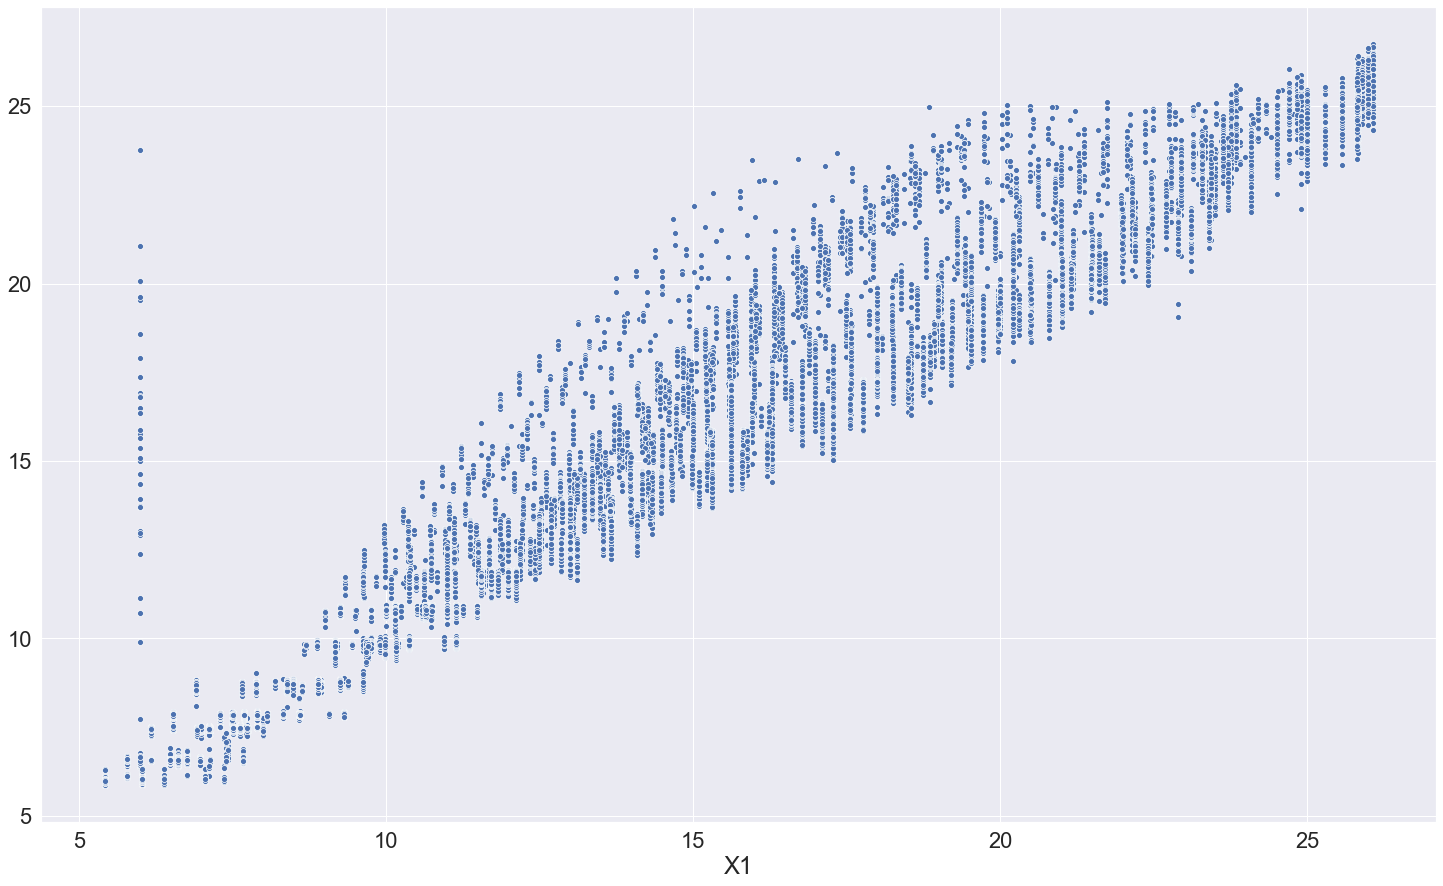

In [127]:
sns.scatterplot(y_train,y_predict4_train)

In [91]:
prediction_result

,Models,ErrorType,Error
0,Linear Regressor,TestingRMSE,0.792000
1,Random Forest Regressor,TestingRMSE,0.393042
2,Support Vector Regressor,TestingRMSE,0.835673
3,Gradient Boosting Regressor,TestingRMSE,0.767057
4,Stacking Regressor,TestingRMSE,0.133248
5,Linear Regressor,TrainingRMSE,0.800601
6,Random Forest Regressor,TrainingRMSE,0.774450
7,Support Vector Regressor,TrainingRMSE,0.842643
8,Gradient Boosting Regressor,TrainingRMSE,0.796037
9,Stacking Regressor,TrainingRMSE,0.818747


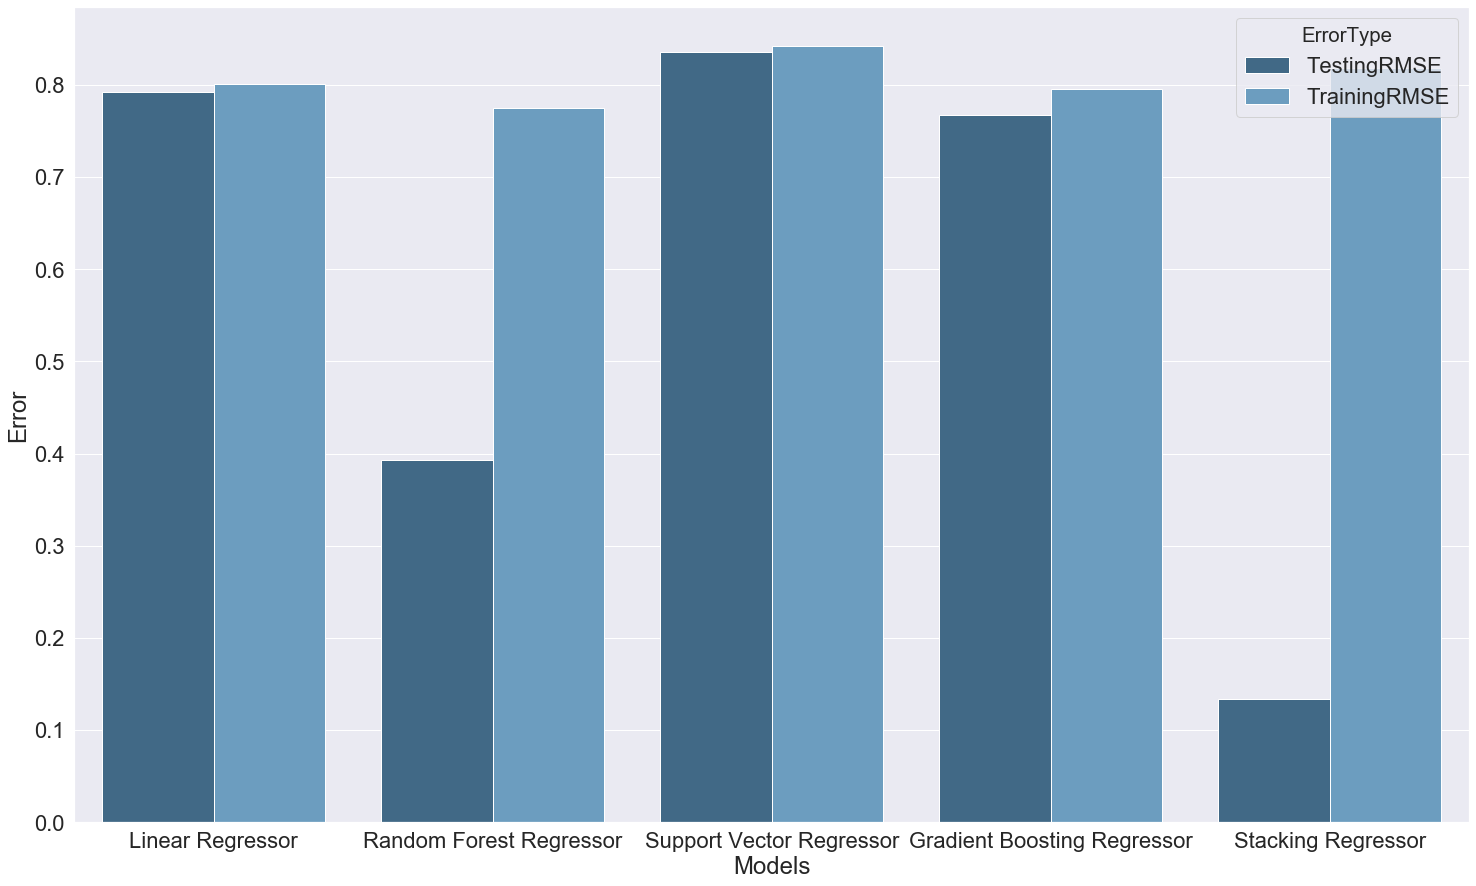

In [120]:
plt=sns.barplot(x="Models", y="Error",hue='ErrorType', data=prediction_result,palette="Blues_d")
#plt.set(ylim=(0.3, 0.9))

In [104]:
loan[loan['X8']=='A']

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,public,delinquency,logX13,X11_new
8,7.88,61390.0,182594.0,4000.0,4000.0,3900.0,36 months,A,A5,NaN,< 1 year,MORTGAGE,148000.0,not verified,Feb-10,credit_card,ilikehorses,775xx,TX,16.98,0.0,May-93,0.0,0.0,0.0,11.0,0.0,50807.0,51.0,19.0,f,0,0,11.904974,under 5 years
17,8.59,67503.0,252415.0,10000.0,10000.0,10000.0,36 months,A,A4,Genesys PHO,1 year,MORTGAGE,56000.0,not verified,Oct-09,debt_consolidation,lukeanthony85,485xx,MI,15.49,0.0,Dec-91,0.0,0.0,0.0,7.0,0.0,6068.0,16.7,49.0,f,0,0,10.933125,under 5 years
18,7.14,68163.0,258249.0,3000.0,3000.0,3000.0,36 months,A,A3,Matrix Resources,9 years,MORTGAGE,100000.0,not verified,Feb-10,small_business,Raising Capital,300xx,GA,6.50,1.0,Feb-98,0.0,16.0,0.0,14.0,0.0,3021.0,4.8,25.0,f,0,1,11.512935,5-10 years
19,8.63,68381.0,260179.0,6625.0,6625.0,6475.0,36 months,A,A5,Albertsons,< 1 year,RENT,13200.0,not verified,Mar-08,debt_consolidation,After college credit card pay down,926xx,CA,9.73,0.0,Dec-03,0.0,0.0,0.0,3.0,0.0,6282.0,44.6,9.0,f,0,0,9.488048,under 5 years
22,8.94,69001.0,265533.0,15000.0,15000.0,14875.0,36 months,A,A5,NaN,< 1 year,MORTGAGE,110000.0,not verified,Sep-09,credit_card,Revolving Debt,146xx,NY,7.07,0.0,Nov-91,1.0,0.0,0.0,6.0,0.0,7586.0,52.7,19.0,f,1,1,11.608245,under 5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399959,6.49,28752684.0,31225809.0,16800.0,16800.0,16800.0,36 months,A,A2,Senior Account Manager,10+ years,MORTGAGE,68000.0,not verified,Oct-14,debt_consolidation,Debt consolidation,488xx,MI,17.86,0.0,Jun-80,0.0,63.0,0.0,11.0,0.0,17096.0,83.8,24.0,f,0,1,11.127278,10+ years
399967,8.39,28752799.0,31225926.0,15000.0,15000.0,15000.0,36 months,A,A5,Sales Admin II,8 years,RENT,NaN,VERIFIED - income source,Oct-14,credit_card,Credit card refinancing,113xx,NY,6.79,0.0,Aug-01,0.0,0.0,0.0,16.0,0.0,18952.0,51.6,23.0,f,0,0,11.286148,5-10 years
399968,8.39,28752808.0,31225935.0,5275.0,5275.0,5275.0,36 months,A,A5,NaN,10+ years,RENT,36495.0,VERIFIED - income,Oct-14,debt_consolidation,Debt consolidation,598xx,MT,20.49,0.0,Jun-93,0.0,39.0,72.0,10.0,1.0,3788.0,51.9,30.0,f,1,1,10.504958,10+ years
399972,8.39,28752840.0,31225969.0,12000.0,12000.0,12000.0,36 months,A,A5,NaN,10+ years,UNKNOWN,50000.0,VERIFIED - income,Oct-14,debt_consolidation,Debt consolidation,633xx,MO,24.56,0.0,Jul-00,2.0,0.0,0.0,10.0,0.0,96700.0,43.9,18.0,w,0,0,10.819798,10+ years


### Final Result

In [387]:

result = pd.DataFrame(y_predict4_heldout)
result.to_csv('result_Lei_Hong.csv')

### Summary

All the models work relatively well and among them Gradient Boosting Regressor returned the most robust result with the lowest RMSE. I fit the models by each subgrade since the grades and subgrades are extremally important features, they might overshadow other features. However, I tried fitting model by subgrades or otherwise, the results are not that different.
- Model 1: Linear regression
Linear regression is the least complex model among all of them. Easy to fit and fast to run. With 0.79 train error and 0.8 testing error without tuning, linear regression does not tend to over-fit. However, the result is not the best among all the models.
- Model 2: Random Forest
Although testing error of random forest is only 0.39, the training error is up to 0.77. definitely over fitting. I tried to tune the parameters but cannot resolve the situation. Apart from that, we can extract feature importance from random forest models to help with feature selection.
- Model 3: Support Vector Regressor
Tried to fit the model using linear, polynomial regressor and find out the result from kernel=linear is pretty much the same as our linear model and polynomial took too much time to run. In the end, settle for rbf, the result shows no-overfitting with 0.84 testing and training error.
- Model 4: Gradient Boosting Regressor
Gradient Boosting Regressor gave the best result (training error 0.77 and testing error 0.79) with a little bit tuning (learning rate from 0.1 to 0.05, n_estimators from 100 to 500)
- Model 5: StackingRegressor (RF and GBR)
Tried to stack random forest and gradient boosting regressor. The result shows overfitting with 0.13 training error and 0.82 testing error. Besides, it took a while to run.
